<a href="https://colab.research.google.com/github/HaroldMDiazVargas/NerveProject/blob/main/Taller1_Harold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 1: Analisis Descriptivo (univariado y multivariado)

## Requerimientos

Modulos a instalar

In [ ]:
import os

def check_module(module, install=True, upgrade=True):
  try:
    __import__(module)
    print(f"Module '{module}' OK")
    if upgrade:
      print(f"Upgrading '{module}'...")
      print(os.popen(f"pip install --user -U {module.replace('_', '-')}").read())
  except ModuleNotFoundError:
    print(f"Module '{module}' not found")
    if install:
      print(f"Installing '{module}'......")
      print(os.popen(f"pip install --user {module.replace('_', '-')}").read())
      print('Installed')
      check_module(module)

In [ ]:
modules = [
  'numpy',
  'scipy',
  'seaborn',
  'matplotlib',
  'sklearn',
  'joblib'
]

[check_module(module) for module in modules];

Importar los modulos


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from joblib import dump, load
import requests, zipfile, io
import numpy as np
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
from pandas.plotting import scatter_matrix
import requests



## Base de Datos
Es una una base de datos de imagenes de ultrasonido correspondiente a planos anatomicos pertinentes para la realización del bloqueo de los nervios periféricos, tomada en pacientes mayores de 18 años. En este caso: nervio mediano y nervio cubital en el antebrazo, ciático al nivel de la fosa poplítea, femoral a nivel del pliegue inguinal.

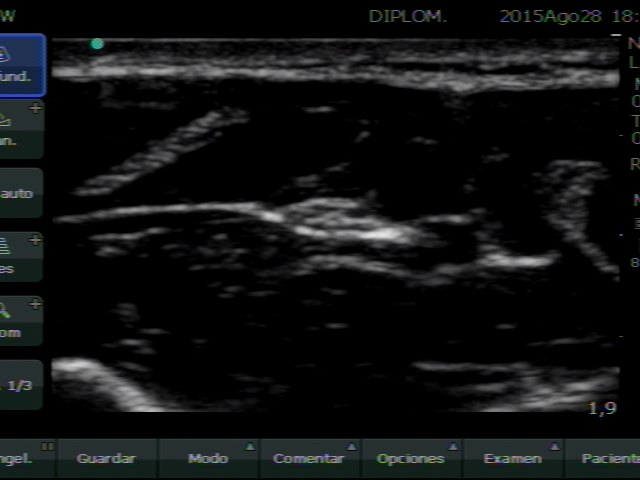


- A partir de las imagenes crudas, se realiza un proceso de selección de la región de interés(ROI).
- Posteriormente, se divide la ROI en superpixeles utilizando el enfoque SLIC-Superpixels.

En la siguiente celda se cargan las imágenes recortadas(ImGC) y los superpixeles(UIdataset). Para realizarlo se utiliza funcion loadmat del modulo scipy, debido a que estan en archivo de extensión .mat

In [92]:
r = requests.get( 'https://github.com/HaroldMDiazVargas/NerveProject/blob/main/USImages.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

path="USImages/"

ImGC = scipy.io.loadmat(path+'ImGC.mat')
UIdataset = scipy.io.loadmat(path+'UIdatasetSP600FM.mat')

Con la siguiente celda se visualiza los Superpixeles para una imagen dada


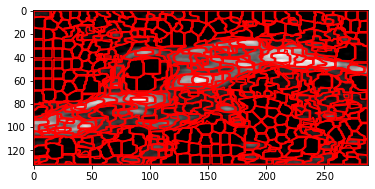

In [8]:
img_ = 20
full_list = []
for j in range(np.max(UIdataset["sp"][img_][0])):
  indices=np.where(UIdataset["sp"][img_][0]==j+1)
  ind = []
  for i in range(len(indices[0])):
    if (indices[0][i]+1 < ImGC["Ic"][img_][0].shape[0] and indices[1][i]+1 < ImGC["Ic"][img_][0].shape[1]):
      if (UIdataset["sp"][img_][0][indices[0][i]-1,indices[1][i]] != j+1 or UIdataset["sp"][img_][0][indices[0][i],indices[1][i]-1] != j+1 or UIdataset["sp"][img_][0][indices[0][i]+1,indices[1][i]] != j+1 or UIdataset["sp"][img_][0][indices[0][i],indices[1][i]+1] != j+1):
        ind.append((indices[0][i],indices[1][i]))
    else:
      ind.append((indices[0][i],indices[1][i]))
  ind_ar = np.asarray(ind)
  unq = np.unique(ind_ar[:,0])
  min = []
  max = []
  for i in unq:
    idx = np.where(ind_ar[:,0]==i)
    val_min = np.min(ind_ar[idx,1])
    val_max = np.max(ind_ar[idx,1])
    min.append((i,val_min))
    max.append((i,val_max))
  max.reverse()
  max.append(min[0])
  min_arr = np.asarray(min)
  max_arr = np.asarray(max)
  full_arr = np.concatenate((min_arr, max_arr))
  full_list.append((full_arr))

for k in range(len(full_list)):
  plt.plot(full_list[k][:,1],full_list[k][:,0],'r')
plt.imshow(ImGC["Ic"][img_][0],cmap="gray")

Para la extracción de caracteristicas de cada superpixel se aplica la transformada Wavelete no lineal, permitiendo dismuir el ruido y artefactos presentes en la imagen. Se obtiene para cada ventana un conjunto de datos númericos(media, std, entropia), con su correspondiente vector de etiquetas con 3 anotadores, indicando 1(nervio) y 0(no nervio).

*  *X*: Conjunto de las 12 caracteristicas
*   *T_anot*: Conjunto de etiqueta de los 3 anotadores

Para efectos de realización del taller, se elimina la caracteristica de entropia y se añade una nueva llamada coeficiente de variación(CV), que es la relación entre el tamaño de la media y la variabilidad de la variable.

Debido a que se desea tener una variable de etiqueta de solo un anotador, se realiza la media de los 3 anotadores y se aproxima al mas cercano. Estos datos se almacenan en *T*.





In [9]:
T_anot = UIdataset["T"]
T=np.round(np.mean(UIdataset["T"],axis=1))
T=T.astype(int)
X=UIdataset["X"]
for i in np.arange(0,11,3):
  X[:,i+2] = X[:,i+1]/ X[:,i]

print("Cantidad de imagenes US: ", ImGC["Ic"].shape[0])
print("Cantidad de superpixeles totales: ", X.shape[0])
print("Cantidad de caracteristicas obtenidas por cada spx: ", X.shape[1])
print("Cantidad de anotadores: ",T_anot.shape[1])

Cantidad de imagenes US:  48
Cantidad de superpixeles totales:  28037
Cantidad de caracteristicas obtenidas por cada spx:  12
Cantidad de anotadores:  3


Los datos no requieren parser, son estructurados y estan organizados en un dataframe(pandas)
- Datos cuantitativos: El conjunto *X* de caracteristicas que son la media, desviación estandar y el coeficiente de variación son variables cuantitativas continuas.
- Datos cualitativos: El conjunto de etiquetas *T*, donde 1 expresa nervio y 0 no-nervio, además cada anotador es una variable nominal.

In [10]:
X_df = pd.DataFrame(X, columns=["m1", "std1","CV1", "m2","std2", "CV2","m3", "std3","CV3", "m4","std4", "CV4"])
T_anotadores = pd.DataFrame(T_anot, columns=["T1","T2","T3"])
T_labels = pd.DataFrame(T, columns=["T"])
full_db  = X_df.copy()
full_db.insert(12,"T",T)
full_db

,m1,std1,CV1,m2,std2,CV2,m3,std3,CV3,m4,std4,CV4,T
0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0
1,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0
2,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0
3,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0
4,1.156250,0.368902,0.319050,2.468750,1.626085,0.658667,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28032,134.676471,20.129461,0.149465,29.941176,10.597144,0.353932,1.264706,0.511019,0.404062,2.588235,1.892852,0.731329,0
28033,171.027027,25.225083,0.147492,62.270270,34.655165,0.556528,1.189189,0.397061,0.333892,2.675676,2.122028,0.793081,0
28034,184.200000,43.709579,0.237294,145.644444,75.818010,0.520569,4.577778,4.402937,0.961807,19.244444,20.063712,1.042572,0
28035,144.030303,32.971090,0.228918,113.393939,53.499380,0.471801,2.515152,2.093460,0.832340,20.090909,10.771385,0.536132,0


## Análisis univariado para cada atributo

In [215]:
med = pd.DataFrame(X_df.mean(axis=0),columns = ["media"]).transpose()
var = pd.DataFrame(X_df.var(axis=0),columns = ["varianza"]).transpose()
pd.concat([med,var])

,m1,std1,CV1,m2,std2,CV2,m3,std3,CV3,m4,std4,CV4
media,68.072735,9.435006,0.294937,18.599768,13.944502,0.743440,5.441324,2.392622,0.387341,7.29172,5.830520,0.683176
varianza,5467.795731,86.542734,0.140155,384.758707,178.218057,0.137203,351.185417,42.786044,0.109356,248.96357,138.050609,0.159870


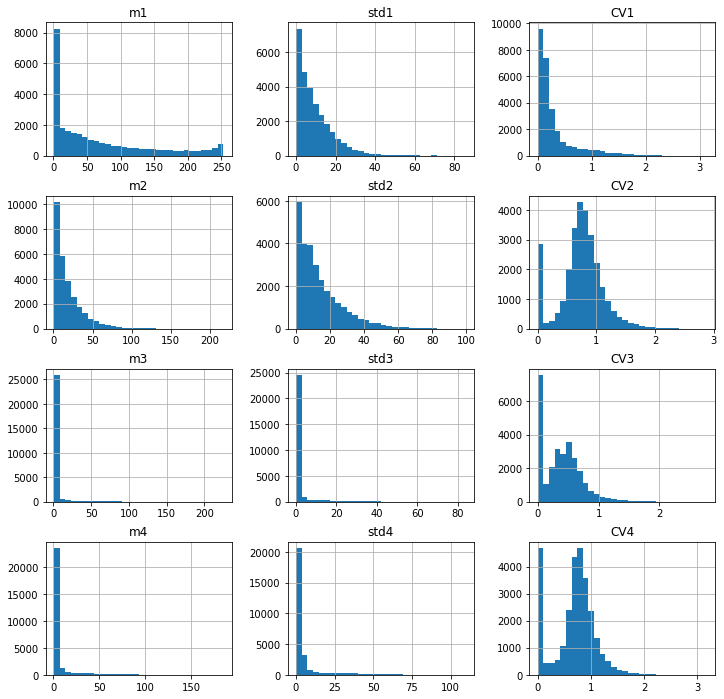

In [216]:
hist = X_df.hist(bins = 30, figsize=(12,12),grid=True)

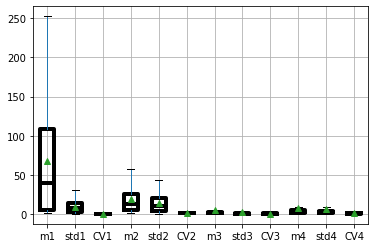

In [217]:
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')
X_df.boxplot(column=["m1", "std1", "CV1","m2", "std2", "CV2","m3", "std3", "CV3","m4", "std4", "CV4"],
          boxprops=boxprops,
                medianprops=medianprops,showfliers=False, showmeans=True,
                  return_type='dict')
plt.show()

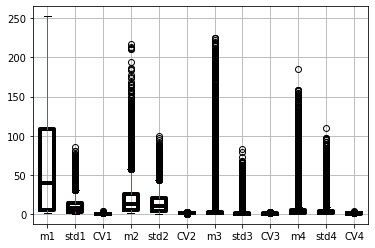

In [218]:
X_df.boxplot(column=["m1", "std1", "CV1","m2", "std2", "CV2","m3", "std3", "CV3","m4", "std4", "CV4"],
          boxprops=boxprops,
                medianprops=medianprops,showfliers=True, showmeans=False,
                  return_type='dict')
plt.show()

De los resultados obtenidos y las diferentes graficas, se puede inferir que:

- No hay valores faltantes(missing values) en ninguna caracteristica ni tampoco en las etiquetas.
- De los histogramas correspondientes a las caracteristicas, se puede observar que no hay una distribución uniforme en la mayoria de estos, esto podría indicar un desbalance de los datos, que más adelante se podría confirmar.Si este no es el caso, entonces podría deberse a que algunos datos podrían ser outliers.
- Del boxplot se puede observar que hay outliers. Se puede analizar que los outliers no representan mucha cantidad de datos, pues la media de los box plots(color verde), no se ve modificada drasticamente por estos outliers. Esto quiere decir, que los outliers posiblemente aportan información bastante util para nuestro estudio en concretido, debido a que representan el nervio, y de nuevo se cae a la suposición de un posible desbalance de datos, que más adelante en el análisis exploratorio se podrá afirmar.

## Análisis de la variable categorica T - Anotadores

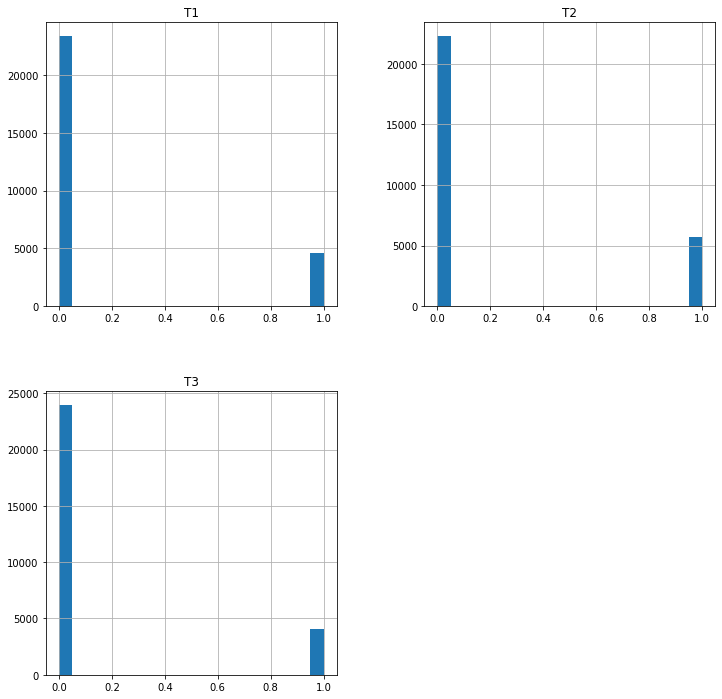

In [ ]:
hist = T_anotadores.hist(bins=20, figsize=(12,12),grid=True)

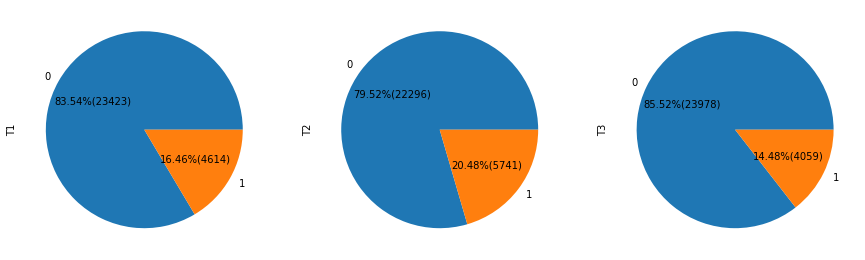

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
for i in range(3):
  cant = T_anotadores.groupby('T'+str(i+1)).size()
  T_anotadores['T'+str(i+1)].value_counts().plot(ax = axes[i],figsize=(15,15), kind='pie', autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*cant.sum()))

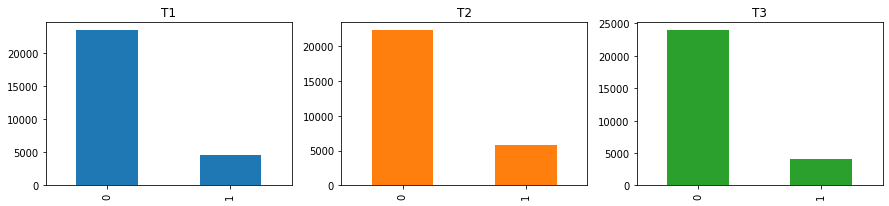

In [209]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') 

fig, axes = plt.subplots(nrows=1, ncols=3)

for i in range(3):
  axes[i].set_title("T"+str(i+1))
  T_anotadores['T'+str(i+1)].value_counts().plot(ax = axes[i],figsize=(15,3), kind='bar',color='C'+str(i))

De lo anterior, se puede observar que existe mucha mas cantidad de superpixeles etiquetados como no-nervio que como nervio, es decir, confirmar lo mencionado previamente que existe un desbalance de los datos. 

También que los anotadores tienen cantidades similares de superpixeles en cuanto a la etiquetación del nervio y no-nervio

## Descriptores vistos en clase para varias variables númericas

In [19]:
select_var = ["std1","m2","CV3","std4"]
var_num = X_df[select_var]
var_num

,std1,m2,CV3,std4
0,0.000000,1.000000,0.000000,0.000000
1,0.000000,1.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000
3,0.000000,1.000000,0.000000,0.000000
4,0.368902,2.468750,0.000000,0.000000
...,...,...,...,...
28032,20.129461,29.941176,0.404062,1.892852
28033,25.225083,62.270270,0.333892,2.122028
28034,43.709579,145.644444,0.961807,20.063712
28035,32.971090,113.393939,0.832340,10.771385


In [20]:
count = pd.DataFrame(var_num.count(axis=0),columns = ["count"]).transpose()
min = pd.DataFrame(var_num.min(axis=0),columns = ["min"]).transpose()
max = pd.DataFrame(var_num.max(axis=0),columns = ["max"]).transpose()
mean = pd.DataFrame(var_num.mean(axis=0),columns = ["media"]).transpose()
med = pd.DataFrame(var_num.median(axis=0),columns = ["mediana"]).transpose()
moda = var_num.mode().rename(index= {0: 'moda'})
quantile = var_num.quantile(q=[.25, .5, .75],axis=0).rename(index= {0.25: 'q0.25',0.50: 'q0.50',0.75: 'q0.75'})
min_arr = min.to_numpy()
max_arr = max.to_numpy()
range_arr = max_arr - min_arr
range_ = pd.DataFrame(data=range_arr,index=["range"], columns=select_var)
var = pd.DataFrame(var_num.var(axis=0),columns = ["varianza"]).transpose()
std = pd.DataFrame(var_num.std(axis=0),columns = ["std"]).transpose()
std_arr = std.to_numpy()
mean_arr = mean.to_numpy()
cv_arr = std_arr/mean_arr
cv = pd.DataFrame(data=cv_arr,index=["cv"], columns=select_var)
skew = pd.DataFrame(var_num.skew(axis=0),columns = ["skewness"]).transpose()
kurt= pd.DataFrame(var_num.kurtosis(axis=0),columns = ["kurtosis"]).transpose()

pd.concat([count,min,max,mean,med,moda,quantile,range_,var,std,cv,skew,kurt])

,std1,m2,CV3,std4
count,28037.000000,28037.000000,28037.000000,28037.000000
min,0.000000,1.000000,0.000000,0.000000
max,85.398337,216.888889,2.780176,109.254977
media,9.435006,18.599768,0.387341,5.830520
mediana,6.953829,12.652174,0.379380,2.010036
moda,0.000000,1.000000,0.000000,0.000000
q0.25,2.642457,4.945946,0.000000,0.821825
q0.50,6.953829,12.652174,0.379380,2.010036
q0.75,13.647370,25.750000,0.581367,3.853653
range,85.398337,215.888889,2.780176,109.254977


De los valores minimos y máximos, se puede observar que las caracteristicas son diferentes en cuanto a su rango.

Se puede ver que la moda para la mayoria de las variables es 0.

La variable m2, es la que mayor varianza tiene y la CV3 la de menos varianza. Lo mismo se mantiene para la desviación estandar.

Se espera que altos valores de outliers causen que el kewness y la kurtosis sean mayores y mas positivas. De estas variables se puede apreciar que la CV3 es la de menor skewness, esto debido a que su distribución presentada arriba tiene mejor simetria que el resto de estas variables analizadas. Lo mismo ocurre para su valor de Kurtosis, aunque su valor es mayor a 1, indicando que la distribución es un poco puntiaguda.





## Valores atípicos(Outliers)

In [221]:
mean=scipy.io.loadmat('USImages/outliers')["mean"]
median=scipy.io.loadmat('USImages/outliers')["median"]
quartiles=scipy.io.loadmat('USImages/outliers')["quartiles"]
gesd=scipy.io.loadmat('USImages/outliers')["gesd"]
grubbs=scipy.io.loadmat('USImages/outliers')["grubbs"]

Los outliers se determinan en este caso para la caracteristica *m1*. A continuación se observa que cada método genera un "umbral" a partir del cual determina si cada dato es outlier o no. Los métodos más flexibles son gesd y grubbs, y el que más outliers clasificó fue median.

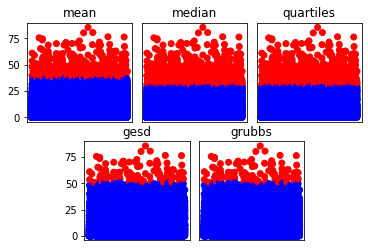

In [224]:
x=np.arange(0,X.shape[0],1)
colormap = np.array(['b','r'])
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2,)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ax1.set_title("mean")
ax1.get_xaxis().set_ticks([])
ax2.set_title("median")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.set_title("quartiles")
ax3.get_yaxis().set_ticks([])
ax3.get_xaxis().set_ticks([])
ax4.set_title("gesd")
ax4.get_xaxis().set_ticks([])
ax5.set_title("grubbs")
ax5.get_xaxis().set_ticks([])
ax5.get_yaxis().set_ticks([])
ax1.scatter(x, X[:,1], c=colormap[mean[:,1]])
ax2.scatter(x, X[:,1], c=colormap[median[:,1]])
ax3.scatter(x, X[:,1], c=colormap[quartiles[:,1]])
ax4.scatter(x, X[:,1], c=colormap[gesd[:,1]])
ax5.scatter(x, X[:,1], c=colormap[grubbs[:,1]])

## Discretización de una variable numérica(CV3)

Se selecciona la variable CV3 para realizar la discretización.

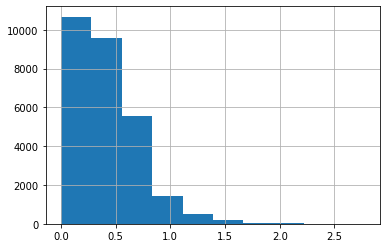

In [74]:
select_var = ["CV3"]
var_num = X_df[select_var]
var_num["CV3"].hist()

A continuación se aplica discretización no supervisada de ancho uniforme, los datos se dividen en k intervalos del mismo ancho:

$w = \dfrac{(max-min)}{k}$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


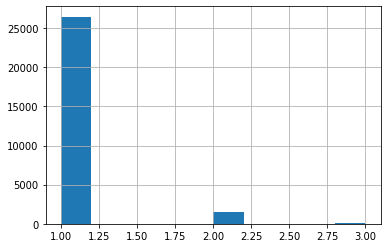

In [75]:
k = 3
w = range_arr[0][2]/k
bin_list = [-np.inf]
label_list = []
var_num_sorted = var_num.sort_values(by=['CV3']).reset_index(drop=True)
var_num_arr = var_num_sorted.to_numpy()
for i in range(k):
  bin_list.append(var_num.min()[0]+w*(i+1))
  label_list.append(i+1)
var_num["CV3_bin1"] = pd.cut(var_num["CV3"],
bins=bin_list,
labels=label_list)
var_num["CV3_bin1"].hist()
plt.show()

Ahora se aplica discretización no supervisada de frecuencia uniforme. Manualmente el código presenta un problema bastante curioso, debido a que los datos son en total 28037, para dividirlos por conjuntos de igual cantidad de datos, solo se pueden en: 23, 53, 529 y 1219, que son los divisores de 28037. Además de que hay mucha cantidad de valores que son 0, por lo que al hacer la discretización queda un bin(el primero) de mayor tamaño, esto debido a que los primeros bins corresponden a valores llenos de ceros, que al graficarlos entonces se apilan.

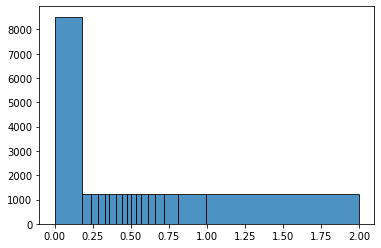

In [80]:
k = 1219 #23,53,529,1219
cond_ = var_num_arr.shape[0] / k
bin_list = []
if cond_.is_integer():
  for i in range(int(cond_)):
    lim_inf = var_num_arr[i*k][0]
    lim_sup = var_num_arr[(i+1)*(k-1)][0]
    if i == 0:
      bin_list.append(lim_inf)
      bin_list.append(lim_sup)
    else:
      bin_list.append(lim_sup)
else:
  print("Seleccione otro valor de k")

plt.hist(var_num_arr, bins = bin_list,alpha=0.8, histtype='bar', ec='black')
plt.show()

Discretización no supervisada de frecuencia uniforme obtenida de Orange:

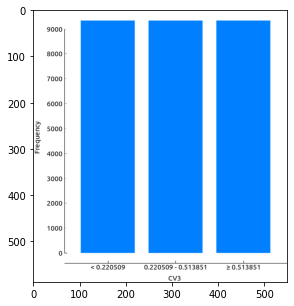

In [91]:
EqF = plt.imread('EqualFrequencyk3.png')
plt.figure(figsize = (5,5))
plt.imshow(EqF)

A  continuación se observa el resultado de la discretización supervisada emplezando el método de la entropía. Este resultado se obtuvo de Orange

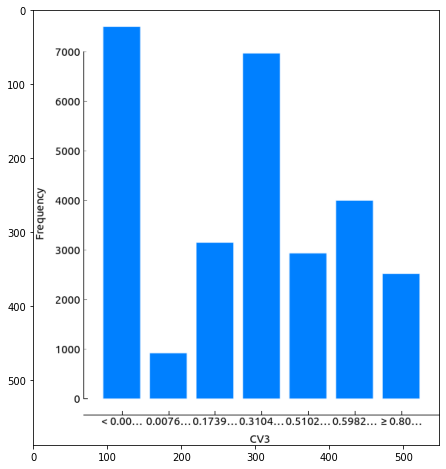

In [89]:
Entro_disct = plt.imread('Entropy.png')
plt.figure(figsize = (7,7))
plt.imshow(Entro_disct)

## Correlación entre variable numéricas

Se presenta las graficas de los scatter entre todas las variables numericas(caracteristicas)

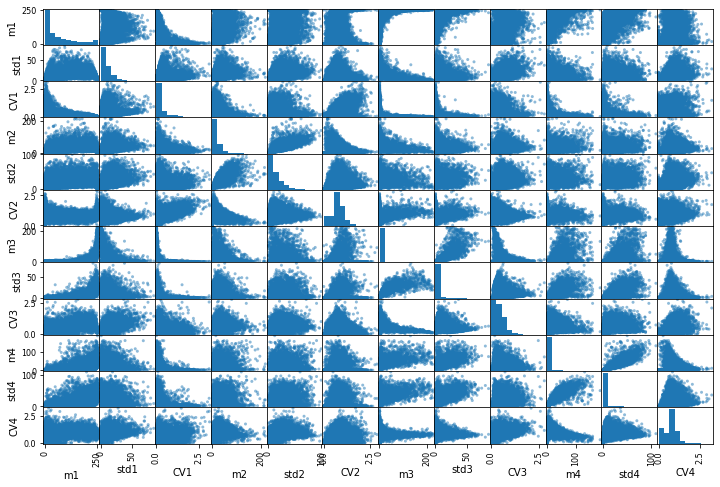

In [28]:
scatter_matrix(X_df,figsize=(12, 8))
plt.show() 

Matriz de correlación con sus indices

In [29]:
corr_matrix = X_df.corr() 
corr_matrix

,m1,std1,CV1,m2,std2,CV2,m3,std3,CV3,m4,std4,CV4
m1,1.000000,0.515080,-0.384446,0.545036,0.575484,0.137185,0.502827,0.626943,0.569065,0.612307,0.651395,0.393248
std1,0.515080,1.000000,0.050614,0.603607,0.633565,0.152636,0.017263,0.195398,0.630351,0.247645,0.339521,0.510993
CV1,-0.384446,0.050614,1.000000,-0.113111,-0.019275,0.495786,-0.148495,-0.173863,-0.122959,-0.172026,-0.159279,0.126639
m2,0.545036,0.603607,-0.113111,1.000000,0.866228,0.016060,0.142598,0.279781,0.491931,0.409280,0.442738,0.390991
std2,0.575484,0.633565,-0.019275,0.866228,1.000000,0.289309,0.224054,0.361396,0.518174,0.426170,0.491768,0.485086
CV2,0.137185,0.152636,0.495786,0.016060,0.289309,1.000000,0.149283,0.143238,0.179773,0.087274,0.124568,0.436100
m3,0.502827,0.017263,-0.148495,0.142598,0.224054,0.149283,1.000000,0.849654,0.045986,0.710705,0.667389,0.054939
std3,0.626943,0.195398,-0.173863,0.279781,0.361396,0.143238,0.849654,1.000000,0.283663,0.785417,0.787792,0.146645
CV3,0.569065,0.630351,-0.122959,0.491931,0.518174,0.179773,0.045986,0.283663,1.000000,0.276748,0.394193,0.621233
m4,0.612307,0.247645,-0.172026,0.409280,0.426170,0.087274,0.710705,0.785417,0.276748,1.000000,0.920135,0.134575


In [ ]:
corr_matrix.style.background_gradient(cmap='coolwarm')

,m1,std1,CV1,m2,std2,CV2,m3,std3,CV3,m4,std4,CV4,T
m1,1.000000,0.515080,-0.384446,0.545036,0.575484,0.137185,0.502827,0.626943,0.569065,0.612307,0.651395,0.393248,0.574346
std1,0.515080,1.000000,0.050614,0.603607,0.633565,0.152636,0.017263,0.195398,0.630351,0.247645,0.339521,0.510993,0.257277
CV1,-0.384446,0.050614,1.000000,-0.113111,-0.019275,0.495786,-0.148495,-0.173863,-0.122959,-0.172026,-0.159279,0.126639,-0.210913
m2,0.545036,0.603607,-0.113111,1.000000,0.866228,0.016060,0.142598,0.279781,0.491931,0.409280,0.442738,0.390991,0.275479
std2,0.575484,0.633565,-0.019275,0.866228,1.000000,0.289309,0.224054,0.361396,0.518174,0.426170,0.491768,0.485086,0.296358
CV2,0.137185,0.152636,0.495786,0.016060,0.289309,1.000000,0.149283,0.143238,0.179773,0.087274,0.124568,0.436100,0.064203
m3,0.502827,0.017263,-0.148495,0.142598,0.224054,0.149283,1.000000,0.849654,0.045986,0.710705,0.667389,0.054939,0.205898
std3,0.626943,0.195398,-0.173863,0.279781,0.361396,0.143238,0.849654,1.000000,0.283663,0.785417,0.787792,0.146645,0.272994
CV3,0.569065,0.630351,-0.122959,0.491931,0.518174,0.179773,0.045986,0.283663,1.000000,0.276748,0.394193,0.621233,0.334093
m4,0.612307,0.247645,-0.172026,0.409280,0.426170,0.087274,0.710705,0.785417,0.276748,1.000000,0.920135,0.134575,0.296357


Con la matriz de correlación pintada como se muestra arriba, es posible de manera visual analizar facilmente relaciones de correlación entre las diferentes variables. Lo primero que se observa es que hay una diagonal de unos, indicando la correlación de una variable con ella misma. Por otro lado, los valores mas altos de correlación son de color naranja, entre más oscuro es el naranja más correlación existe. Se observa que la correlación más alta es de *std4* con *m4*,esto se confirma con el scatter plot previo, donde es una figura que tiende a ser bastante lineal. Si la correlación es baja, pero positiva tiene un color blanco, lo que indicaria posible indipendencia entre dischas variables. Por último, las correlaciones negativas entre más lo sean, estan de color morado oscuro.

## Modelo de regresión lineal

Se tiene que la correlación más alta es entre *std4* y *m4*, como se observa a continuación

In [30]:
corr_matrix["std4"].sort_values(ascending=False)

std4    1.000000
m4      0.920135
std3    0.787792
m3      0.667389
m1      0.651395
std2    0.491768
m2      0.442738
CV3     0.394193
std1    0.339521
CV4     0.299160
CV2     0.124568
CV1    -0.159279
Name: std4, dtype: float64

En el scatter plot se observa un comportamiento lineal

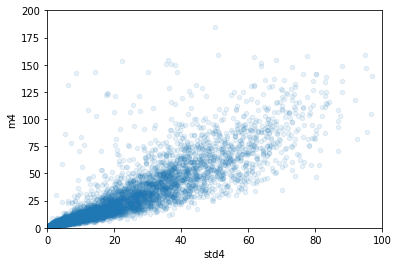

In [33]:
X_df.plot(kind="scatter", x="std4", y="m4", alpha=0.1)
plt.axis([0, 100, 0, 200])
plt.show()

Se toma como variable *y=m4* y variable *x = std4*. Primero se quiere hacer, es la partición de los datos estratificada de acuerdo a la variable *m4*, con el fin de que los conjuntos de entrenamiento y de prueba queden bien proporcionados.




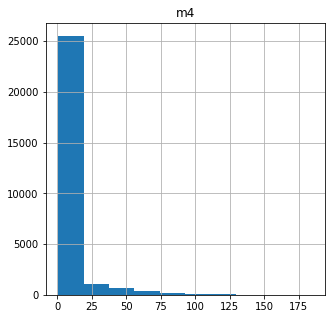

In [34]:
db_mode_copy = pd.DataFrame(X_df[["m4","std4"]].copy())
X_linear_model = pd.DataFrame(db_mode_copy["std4"], columns=["std4"])
labels = pd.DataFrame(db_mode_copy["m4"], columns=["m4"])
labels.hist(bins=10, figsize=(5,5),grid=True)
plt.show()

Se discretiza la variable en diferentes bins

1    25565
2     1124
3      644
4      371
5      186
6      147
Name: bin, dtype: int64


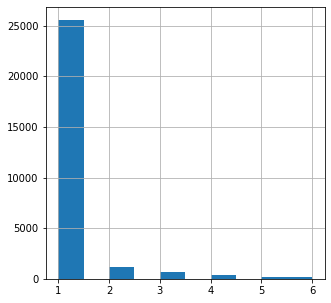

In [35]:
X_linear_model["bin"] = pd.cut(labels["m4"],
bins=[-np.inf, 20., 40., 60., 80., 100., np.inf],
labels=[1, 2, 3, 4, 5, 6])
print(X_linear_model["bin"].value_counts())
X_linear_model["bin"].hist(bins=10,figsize=(5,5),grid=True)

La siguiente función que permite la partición recibe: 

*   df: Dataframe de las caracteristicas
*   y: Los datos y
*   col: La columna en base a la cual se quiere hacer la estratificación
*   p: Porcentaje de partifición

In [36]:
def StratifiedSplit(df,y,col, p):
  split = StratifiedShuffleSplit(n_splits=1, test_size=p, random_state=42)
  for train_index, test_index in split.split(df, df[col]):
    pd_train_set = df.iloc[train_index]
    print(pd_train_set["bin"].value_counts() / len(pd_train_set))
    pd_train_set = pd_train_set.drop(["bin"],axis=1)
    strat_train_set = np.c_[pd_train_set]

    pd_test_set = df.iloc[test_index]
    print(pd_test_set["bin"].value_counts() / len(pd_test_set))
    pd_test_set = pd_test_set.drop(["bin"],axis=1)
    strat_test_set = np.c_[pd_test_set]

    pd_y_train = y.iloc[train_index]
    y_train = np.c_[pd_y_train]
    pd_y_test  = y.iloc[test_index]
    y_test = np.c_[pd_y_test]
  return strat_train_set, y_train, strat_test_set, y_test

Se realiza la regresión y se gráfica el modelo obtenido

1    0.911811
2    0.040082
3    0.022961
4    0.013242
5    0.006643
6    0.005261
Name: bin, dtype: float64
1    0.911912
2    0.040121
3    0.023003
4    0.013195
5    0.006598
6    0.005171
Name: bin, dtype: float64
0.07271323496417192 1.238559732431479


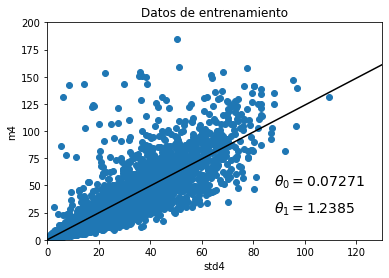

In [ ]:
p = 0.20

X_strat_train_model, y_train, X_strat_test_model, y_test  =  StratifiedSplit(X_linear_model, labels,"bin", p)

lin_reg = LinearRegression()
lin_reg.fit(X_strat_train_model, y_train)
t0, t1 = lin_reg.intercept_[0], lin_reg.coef_[0][0]
print(t0, t1)

plt.scatter(X_strat_train_model,y_train)
plt.title("Datos de entrenamiento")
plt.xlabel("std4")
plt.ylabel("m4")
plt.axis([0, 130, 0, 200])
X_ax=np.linspace(0, 130, 100)
plt.plot(X_ax, t0 + t1*X_ax, "black")
plt.text(88, 50, r"$\theta_0 = 0.07271$", fontsize=14, color="black")
plt.text(88, 25, r"$\theta_1 = 1.2385 $", fontsize=14, color="black")
plt.show()


Predicción para un dato dado(indx)

Se realiza la predicción para un dato dado por la variable indx, se grafica tanto el valor de predicción como el valor real, con el fin de observar visualmente el error

In [ ]:
indx = 120
X_lm_predictions = lin_reg.predict(X_strat_test_model)
print("Real:", y_test[indx],"Predict:",X_lm_predictions[indx])

Real: [62.50909091] Predict: [60.01841321]


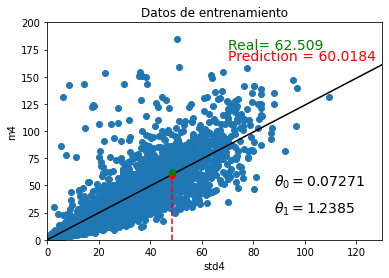

In [ ]:
plt.scatter(X_strat_train_model,y_train)
plt.title("Datos de entrenamiento")
plt.xlabel("std4")
plt.ylabel("m4")
plt.axis([0, 130, 0, 200])
X_ax=np.linspace(0, 130, 100)
plt.plot(X_ax, t0 + t1*X_ax, "black")
plt.text(88, 50, r"$\theta_0 = 0.07271$", fontsize=14, color="black")
plt.text(88, 25, r"$\theta_1 = 1.2385 $", fontsize=14, color="black")

plt.plot([X_strat_test_model[indx], X_strat_test_model[indx]], [0, X_lm_predictions[indx]], "r--")
plt.plot(X_strat_test_model[indx], X_lm_predictions[indx], "ro")
plt.text(70, 165, r"Prediction = 60.0184", fontsize=14, color="r")
plt.plot(X_strat_test_model[indx], y_test[indx], "go")
plt.text(70, 175, r"Real= 62.509", fontsize=14, color="g")

plt.show()

Calculo de los error MSE y MAE para el conjunto test en relación a los valores de predicción

In [ ]:
lin_mse = mean_squared_error(y_test, X_lm_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_mae = mean_absolute_error(y_test, X_lm_predictions)


print("Mean Squared Error:",lin_rmse)
print("Mean Absolute Error:", lin_mae)

Mean Squared Error: 5.954277788337548
Mean Absolute Error: 2.039038176120278


Este modelo efectivamente sirve como modelo de predicción para esos valores dados de la variable *std4*. Sin embargo, el problema que se acabarca de la base de datos es un problema de clasificación de nervio, por lo que este modelo no serviria.

Los errores obtenidos del modelo son relativamente bajos, aunque se podria mejorar utilizando modelo lineal con regularización.

## Matriz de covarianza

Se calcula la matriz de covarianza de las 12 caracteristicas, se obtiene una matriz cuadrada de 12x12

In [37]:
cov_matrix = X_df.cov() 
cov_matrix

,m1,std1,CV1,m2,std2,CV2,m3,std3,CV3,m4,std4,CV4
m1,5467.795731,354.320150,-10.642558,790.543633,568.087801,3.757459,696.775780,303.239101,13.915183,714.402968,565.938889,11.626688
std1,354.320150,86.542734,0.176274,110.144737,78.683270,0.525962,3.009499,11.890103,1.939180,36.350641,37.110881,1.900702
CV1,-10.642558,0.176274,0.140155,-0.830626,-0.096335,0.068751,-1.041802,-0.425759,-0.015222,-1.016174,-0.700621,0.018956
m2,790.543633,110.144737,-0.830626,384.758707,226.830950,0.116689,52.417578,35.897397,3.190943,126.672516,102.037660,3.066511
std2,568.087801,78.683270,-0.096335,226.830950,178.218057,1.430600,56.052734,31.558043,2.287557,89.769073,77.135728,2.589276
CV2,3.757459,0.525962,0.068751,0.116689,1.430600,0.137203,1.036236,0.347049,0.022021,0.510073,0.542134,0.064588
m3,696.775780,3.009499,-1.041802,52.417578,56.052734,1.036236,351.185417,104.150532,0.284983,210.148204,146.949045,0.411655
std3,303.239101,11.890103,-0.425759,35.897397,31.558043,0.347049,104.150532,42.786044,0.613585,81.062327,60.545454,0.383533
CV3,13.915183,1.939180,-0.015222,3.190943,2.287557,0.022021,0.284983,0.613585,0.109356,1.444018,1.531610,0.082141
m4,714.402968,36.350641,-1.016174,126.672516,89.769073,0.510073,210.148204,81.062327,1.444018,248.963570,170.584161,0.849019


Para una mejor interpretabilidad de la matriz de covarianza, se realiza un mapa de calor con el fin de analizar la relación en base a los colores entre las variables

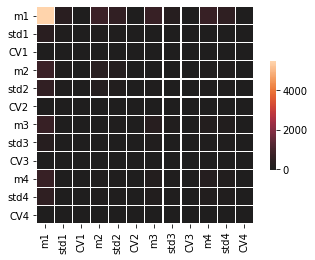

In [38]:
sns.heatmap(cov_matrix,vmax=5468, center=0,  square=True,linewidths=.2,cbar_kws={"shrink": .5})
plt.show()

De la matriz de la covarianza, se puede observar que entre mayor covarianza exista entre dos variables, el color tiende a ser más claro. Se puede ver que la covarianza entre la misma variable(m1) con ella misma es bastante alta, lo que concuerda con resultados previos, donde esta variable es la que mayor varianza y media tiene en la base de datos. Por otro lado, hay diferentes par de variables con una covarianza notable como por ejemplo *m2* con *m1*, *m4* con *m1*, esto indica la fuerza de la relación entre ambas variables. Muchas variablestienen baja relación entre ellas, debido a que hay muchos valores de la matriz de covarianza bajos como se puede analizar, basicamente colores oscuros. 

## t-test

El t-test o Student's T test, compara dos metrias y dice que tan diferentes es una de la otra, al igual que tan significante son. En otras palabras, si estas diferencias podrian haber pasado por pura coincidencia.



*   Un largo valor de *t-score* indica que son grupos son diferentes
*   Un bajo valor de *t-score* indica que los grupos son similares
*   *P-value* es un valor que indica la probabilidad de que los resultados de los datos ocurrieron por pura coincidencia, bajos valores de *p* son buenos. En la mayoria de los casos, valor de *p* de 5% es aceptado para comprobar que los datos son validos.





**t-test univariado**

Primero se seleccionan dos caracteristicas : *std1* y *std2*

In [ ]:
Two_samples = X[["std1","std2"]].to_numpy()
print("std1 mean: ", np.mean(Two_samples[:,0]))
print("std2 mean: ", np.mean(Two_samples[:,1]))

std1 mean:  9.435005992510465
std2 mean:  13.94450190276996


Se selecciona cualquiera de las dos, y se valida el t-test. Esto se realiza con el fin de comprobar si la media los datos de un grupo de observaciones independientes es igual a la media de una población dada(*popmean*)

In [ ]:
popmean = 9
One_sample = Two_samples[:,0]
scipy.stats.ttest_1samp(One_sample,popmean)

Ttest_1sampResult(statistic=7.829710491093791, pvalue=5.061836454144329e-15)

Al variar el valor de *popmean*, se observa como el estadistico t cambia, indicando si se cumple o no la hipotesis

**t-test pareado**

Ahora se quiere verificar si dos grupos de datos independientes tienen valores de media iguales. Este test asume que las poblaciones tienen varianzas identifcas por defecto.

*  Arriba se habia analizado que la media de un grupo es 9.43 y del otro es 13.94. Por lo que el *t-score* negativo indica que la media 2 es mayor que la 1, su valor de 46 da un indicio de que tan diferente son. Algo bueno es que el *p-value* es 0

In [ ]:
Two_samples = X[["std1","std2"]].to_numpy()
scipy.stats.ttest_ind(Two_samples[:,0], Two_samples[:,1])

Ttest_indResult(statistic=-46.40523034063592, pvalue=0.0)

## Análisis de componente principal a base de datos numerica(PCA)

Primero se debe realizar StandardScaler de los datos, es decir, que tengan mdia 0 y varianza 1

In [40]:
num_db_x = StandardScaler().fit_transform(X)
num_db_y = T_labels.to_numpy()
num_db_x


array([[-0.90708424, -1.01422572, -0.78783015, ..., -0.39875786,
        -0.49624465, -1.70866552],
       [-0.90708424, -1.01422572, -0.78783015, ..., -0.39875786,
        -0.49624465, -1.70866552],
       [-0.90708424, -1.01422572, -0.78783015, ..., -0.39875786,
        -0.49624465, -1.70866552],
       ...,
       [ 1.57049226,  3.68438061, -0.15397506, ...,  0.75754204,
         1.21140927,  0.89886932],
       [ 1.02724173,  2.53003571, -0.17634992, ...,  0.81118944,
         0.42052477, -0.36776621],
       [-0.17841709,  0.05549035, -0.30347384, ..., -0.16045586,
        -0.18229178,  0.22951017]])

Se aplica PCA con n_comp = 6 componentes

In [41]:
from sklearn.decomposition import PCA
n_comp = 6
pca = PCA(n_components=n_comp)
num_db_x_pca = pca.fit_transform(num_db_x)
num_db_x_pca_df = pd.DataFrame(data = num_db_x_pca
             , columns = ['pc1', 'pc2', 'pc3','pc4','pc5','pc6'])
num_db_x_pca_df

,pc1,pc2,pc3,pc4,pc5,pc6
0,-2.626531,1.953787,-1.439001,0.452137,0.426558,0.011697
1,-2.626531,1.953787,-1.439001,0.452137,0.426558,0.011697
2,-2.626531,1.953787,-1.439001,0.452137,0.426558,0.011697
3,-2.626531,1.953787,-1.439001,0.452137,0.426558,0.011697
4,-2.423202,1.275918,0.158406,0.573766,-0.045603,-0.366025
...,...,...,...,...,...,...
28032,0.318290,-0.504672,-1.452806,-0.012201,0.390199,-0.688950
28033,1.799834,-1.599405,-1.724102,1.401554,-0.787083,-0.783036
28034,6.579838,-3.867873,-2.995403,4.074061,-0.630846,-0.035247
28035,4.160971,-2.414156,-2.616799,3.329676,-0.260374,-0.413747


In [42]:
full_num_db_pca_df = pd.concat([num_db_x_pca_df, full_db[['T']]], axis = 1)
full_num_db_pca_df 

,pc1,pc2,pc3,pc4,pc5,pc6,T
0,-2.626531,1.953787,-1.439001,0.452137,0.426558,0.011697,0
1,-2.626531,1.953787,-1.439001,0.452137,0.426558,0.011697,0
2,-2.626531,1.953787,-1.439001,0.452137,0.426558,0.011697,0
3,-2.626531,1.953787,-1.439001,0.452137,0.426558,0.011697,0
4,-2.423202,1.275918,0.158406,0.573766,-0.045603,-0.366025,0
...,...,...,...,...,...,...,...
28032,0.318290,-0.504672,-1.452806,-0.012201,0.390199,-0.688950,0
28033,1.799834,-1.599405,-1.724102,1.401554,-0.787083,-0.783036,0
28034,6.579838,-3.867873,-2.995403,4.074061,-0.630846,-0.035247,0
28035,4.160971,-2.414156,-2.616799,3.329676,-0.260374,-0.413747,0


Se grafican las componentes entre ellas, en base a la variable target

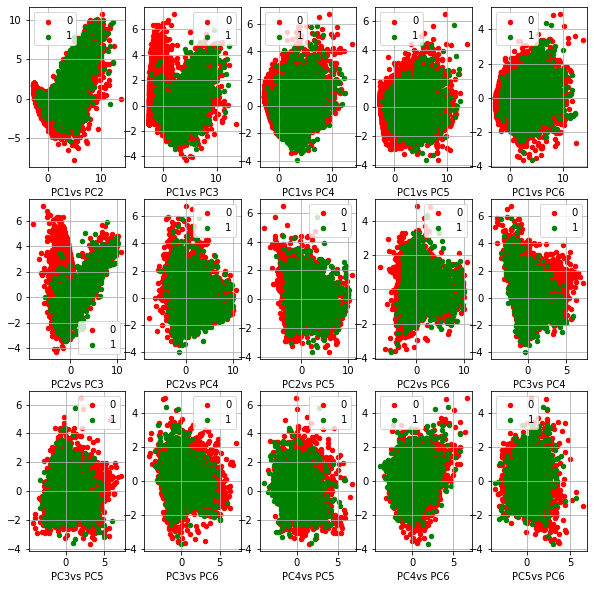

In [50]:
fig = plt.figure(figsize = (10,10))
# fig.tight_layout(pad=10.0)
dict_pca = {'0':(1,2),'1':(1,3),'2':(1,4),'3':(1,5),'4':(1,6),'5':(2,3),'6':(2,4) ,
            '7':(2,5),'8':(2,6),'9':(3,4),'10':(3,5),'11':(3,6),'12':(4,5),'13':(4,6),'14':(5,6)}
l = 0
for i in range(3):
  for j in range(5):
    
    ax = fig.add_subplot(3,5,l+1) 
    ax.set_xlabel('PC'+str(dict_pca[str(l)][0])+'vs PC'+str(dict_pca[str(l)][1]), fontsize = 10)
    # ax.set_ylabel('Principal Component'+str(dict_pca[str(l)][1]), fontsize = 7)
    targets = [0, 1]
    colors = ['r', 'g']
    

    for target, color in zip(targets,colors):
        indicesToKeep = full_num_db_pca_df['T'] == target
        ax.scatter(full_num_db_pca_df .loc[indicesToKeep, 'pc'+str(dict_pca[str(l)][0])]
                  , full_num_db_pca_df .loc[indicesToKeep, 'pc'+str(dict_pca[str(l)][1])]
                  , c = color
                  , s = 20)
    l += 1
    ax.legend(targets)
    ax.grid()

Se toma 6 componentes, ya que explican el 91.2% de la varianza

In [51]:
np.sum(pca.explained_variance_ratio_)*100

91.26179525329108

## Review de la base de datos numerica: 

Hasta el momento se tiene entonces dos bases de datos que se pueden utilizar para tarea de clasificación, que es a lo que se quiere llevar a cabo en este notebook:

*  *num_db_x*: Base de datos numerica de 12 caracteristicas ya estandarizada(cruda)
*  *num_db_x*: Base de datos numerica de 6 caracteristicas ya estandarizada(obtenida de PCA)
*  *num_db_y*: Conjunto de etiquetas

## Trabajando directamente con las imagenes(Superpixeles)
También se puede trabajar con los superpixeles(imagenes), se debe entonces realizar una manera de que tengan el mismo tamaño. Para esto se propone agregar píxeles a los superpíxeles incompletos. Quedando de tamaño 7x7

In [57]:
spx = []
for i in range(UIdataset["sp"].shape[0]):
  for j in range(np.max(UIdataset["sp"][i][0])):
    ar = np.zeros((7,7))
    indices=np.where(UIdataset["sp"][i][0]==j+1)
    ref = [np.min(indices[0]),np.min(indices[1])]
    dif_i = UIdataset["sp"][i][0].shape[0]-ref[0]-7
    dif_j = UIdataset["sp"][i][0].shape[1]-ref[1]-7
    if dif_i >= 0 and dif_j >= 0:
      ref = ref
    else:
      if dif_i < 0:
        ref[0] = ref[0]+dif_i
      if dif_j < 0:
        ref[1] = ref[1]+dif_j
    for k in range(ar.shape[0]):
      for l in range(ar.shape[1]):
        ar[k,l] = ImGC["Ic"][i][0][ref[0]+k][ref[1]+l]
    spx.append(ar)
spx_arr = np.asanyarray(spx)
print(spx_arr.shape)

(28037, 7, 7)


A continuación se observan algunos ejemplos de superpixeles marcados como nervios y como no-nervio

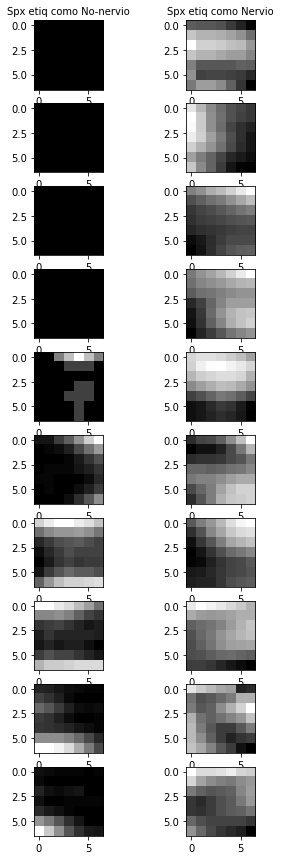

In [56]:
fig = plt.figure(figsize = (5,15))

indx_0 = np.where(T==0)
indx_1 = np.where(T==1)
img = 10
for i in range(img):
  ax = fig.add_subplot(img,2,2*i+1) 
  if i == 0:
    ax.set_title('Spx etiq como No-nervio', fontsize = 10)
  ax.imshow(spx_arr[indx_0[0][10+i]],cmap = "gray")
  ax = fig.add_subplot(img,2,2*i+2) 
  if i == 0:
    ax.set_title('Spx etiq como Nervio', fontsize = 10)
  ax.imshow(spx_arr[indx_1[0][10+i]],cmap = "gray")

plt.show()

## Análisis de componente principal a los superpixeles(PCA)

Al igual que a la base de datos de caracteristicas, a las imagenes se les puede aplicar PCA para reducir la dimensión de las caracteristicas. En este caso cada imagen corresponde a una instancia y sus atributos son 7x7 pixeles, es decir, 49 pixeles(caracteristicas)

In [58]:
spx_arr_reshape = np.reshape(spx_arr,(spx_arr.shape[0],spx_arr.shape[1]*spx_arr.shape[2]))
scaler = StandardScaler()
scaler.fit(spx_arr_reshape)
spx_db_x =scaler.transform(spx_arr_reshape)

Se restringe a que el PCA debe explicar el 95% de la varianza. Se obtienen 2 componentes y se grafican como se muestra a continuación

(2, 49)


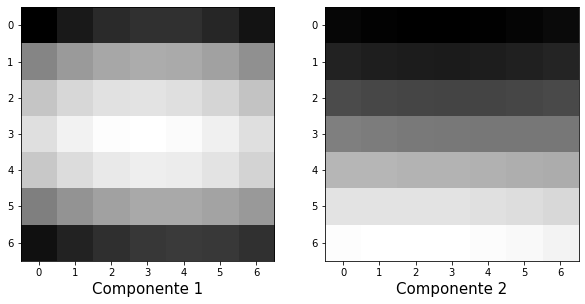

In [59]:
pca = PCA(.95)
pca.fit(spx_db_x)

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,2,1) 
ax.imshow(pca.components_[0].reshape(7,7),cmap="gray")
ax.set_xlabel('Componente 1', fontsize = 15)

ax = fig.add_subplot(1,2,2) 
ax.imshow(pca.components_[1].reshape(7,7),cmap="gray")
ax.set_xlabel('Componente 2', fontsize = 15)
print(pca.components_.shape)
plt.show()

A manera de visualización y prueba, se quiere observar la imagen obtenida de la transformada inversa utilizando estos componentes en relación a la imagen original. Es de esperar que las imagenes sean diferentes, pero que al menos tengan algunas cosas en común

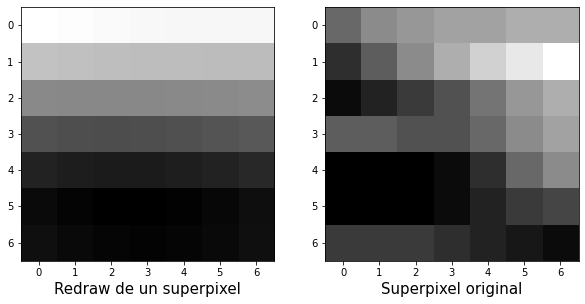

In [61]:
spx_db_x_pca = pca.transform(spx_db_x)
projected = pca.inverse_transform(spx_db_x_pca)

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,2,1) 
ax.imshow(projected[1200].reshape(7,7),cmap="gray")
ax.set_xlabel('Redraw de un superpixel', fontsize = 15)

ax = fig.add_subplot(1,2,2) 
ax.imshow(spx_arr[1200].reshape(7,7),cmap="gray")
ax.set_xlabel('Superpixel original', fontsize = 15)


plt.show()

## Review de todas las bases de datos a analizar

Se tienen los siguientes conjuntos de datos:

*  *num_db_x*: Base de datos numerica de 12 caracteristicas ya estandarizada(cruda)
*  *num_db_x*: Base de datos numerica de 6 caracteristicas ya estandarizada(obtenida de PCA)
* spx_db_x: Base de datos de las imagenes(spx) ya estandarizada(cada imagen es de 7x7)
* spx_db_x_pca: Base de datos de las imagenes(spx) ya estandarizada y con PCA(2 columnas)
*  *num_db_y*: Conjunto de etiquetas

In [ ]:
#Division de todos los datos, preparacion para tarea de clasificacion

In [167]:
# num_db_x.shape 
# num_db_x_pca.shape
# spx_db_x.shape
# spx_db_x_pca.shape
# num_db_y.shape
# db_list = []
# db_list.append((num_db_x,num_db_x_pca, spx_db_x,spx_db_x_pca))
# db_dict = {'0':'num_db_x','1':'num_db_x_pca','2':'spx_db_x','3':'spx_db_x_pca'}

(28037, 2)

In [168]:
num_db_x.shape[1] 

12

In [149]:
np.argmax(acc) 

1

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
red1 (Dense)                 (None, 100)               1300      
_________________________________________________________________
hred4 (Dense)                (None, 50)                5050      
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


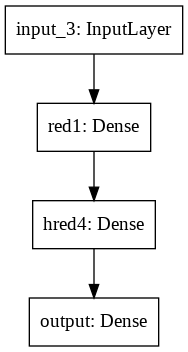

In [162]:
#definir arquitectura secuencial
import tensorflow as tf

loss = "binary_crossentropy"
optimizer = "Adam"
metrics = "accuracy"
model_sequential = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_shape)),
    tf.keras.layers.Dense(100,activation="relu", name='red1'),
    tf.keras.layers.Dense(50, activation="relu",name='hred1'),
    tf.keras.layers.Dense(1,activation='sigmoid',name='output')
])

model_sequential.summary()
tf.keras.utils.plot_model(model_sequential)

In [163]:
model_sequential.compile(loss=loss, #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=metrics) #f1, precision, recall, crossentropy

In [177]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

k_folds = 5
y = num_db_y
Nc = len(np.unique(y))
for dataset in range(len(db_list[0])):
  acc =np.zeros(k_folds)
  acc2 =np.zeros(k_folds)
  cmc = np.zeros((k_folds,Nc,Nc))
  cmc2 = np.zeros((k_folds,Nc,Nc))
  models_clf = []
  models_nn = []
  Xraw = db_list[0][dataset]
  input_shape = Xraw.shape[1]

  model_sequential = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(input_shape)),
      tf.keras.layers.Dense(100,activation="relu", name='red1'),
      tf.keras.layers.Dense(50, activation="relu",name='hred1'),
      tf.keras.layers.Dense(1,activation='sigmoid',name='output')])

  model_sequential.compile(loss=loss, #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=metrics) #f1, precision, recall, crossentropy

  for cv_k in range(k_folds):
    X_train, X_test, y_train, y_test = train_test_split(Xraw,y,test_size=0.2, stratify=y)

    clf = DecisionTreeClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc[cv_k] = 100*accuracy_score(y_test, y_pred)
    cmc[cv_k] = confusion_matrix(y_test, y_pred)
    cmc[cv_k] = 100*cmc[cv_k].astype('float') / cmc[cv_k].sum(axis=1)[:, np.newaxis]
    models_clf.append(clf)

    history = model_sequential.fit(X_train, y_train, epochs=10,batch_size=128,verbose=0) 
    y_pred2 = model_sequential.predict_classes(X_test)
    acc2[cv_k] = 100*accuracy_score(y_test, y_pred2)
    cmc2[cv_k] = confusion_matrix(y_test, y_pred2)
    cmc2[cv_k] = 100*cmc2[cv_k].astype('float') / cmc2[cv_k].sum(axis=1)[:, np.newaxis]
    models_nn.append(model_sequential)
    # print("Generando los diferentes modelos para la base de datos:"+db_dict[str(dataset)])

  savedata1 = {
  'acc':acc,
  'confusionmatrix':cmc,
  'models':models_clf,
    } 
  dump(savedata1,'Model_DTC_'+db_dict[str(dataset)]+'.joblib')

  savedata2 = {
  'acc':acc2,
  'confusionmatrix':cmc2,
  'models':models_nn,
    } 
  dump(savedata2,'Model_NN_'+db_dict[str(dataset)]+'.joblib')

  #   dump(savedata,'results/BCI2a.joblib')
  # print(np.max(acc))
  # np.argmax(acc) 

 

TypeError: ignored

In [ ]:
model_sequential.evaluate(X_test, y_test)

In [185]:
savedata2 = {
  'acc':acc2,
  'confusionmatrix':cmc2,
  'models':model_sequential,
    } 
dump(savedata2,'p1.joblib')

TypeError: ignored

In [ ]:
def income_cat_proportions(data):
    return data["T_bin"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

IndexError: ignored

In [ ]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.832543,0.832561,0.834879,0.280590,0.002152
2,0.167457,0.167439,0.165121,-1.395002,-0.010699


In [ ]:
del strat_train_set["T_bin"]
strat_train_set = strat_train_set.reset_index(drop=True)
strat_train_set.hist(bins=10, figsize=(10,10),column=["e1","e2","e4","T"],grid=True)
# save_fig("attribute_histogram_plots")
plt.show()

ValueError: ignored

In [ ]:
c2 = strat_train_set.loc[strat_train_set['T'] == 1]
c1 = strat_train_set.loc[strat_train_set['T'] == 0]

AttributeError: ignored

In [ ]:
len(c1)

18673

In [ ]:
# a = strat_train_set["T"].where(strat_train_set["T"] ==1)
c2 = strat_train_set.loc[strat_train_set['T'] == 1]
strat_train_set = strat_train_set.append([c2]*3)
# c1 = strat_train_set.loc[strat_train_set['T'] == 0]



# strat_train_set["T_bin"] = pd.cut(strat_train_set["T"],
# bins=[-np.inf, 0.5, np.inf],
# labels=[1, 2])
# strat_train_set["T_bin"].value_counts()

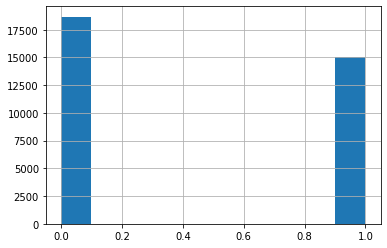

In [ ]:
strat_train_set["T"].hist()

In [ ]:
strat_train_set["T_bin"] = pd.cut(strat_train_set["T"],
bins=[-np.inf, 0.5, np.inf],
labels=[1, 2])
strat_train_set["T_bin"].value_counts()

1    18673
2    15024
Name: T_bin, dtype: int64

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
strat_train_set = strat_train_set.dropna()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(strat_train_set, strat_train_set["T_bin"]):
    strat_tr_set = strat_train_set.iloc[train_index]
    strat_val_set = strat_train_set.iloc[test_index]

In [ ]:
del strat_tr_set["T_bin"]
strat_tr_set = strat_tr_set.reset_index(drop=True)
T_train = strat_tr_set["T"]
T_train = T_train.to_numpy()
del strat_tr_set["T"]
strat_tr_set = strat_tr_set.to_numpy()

del strat_val_set["T_bin"]
strat_val_set = strat_val_set.reset_index(drop=True)
T_val = strat_val_set["T"]
T_val = T_val.to_numpy()
del strat_val_set["T"]
strat_val_set = strat_val_set.to_numpy()

In [ ]:
T_train

array([0, 0, 0, ..., 1, 0, 0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
red1 (Dense)                 (None, 100)               1300      
_________________________________________________________________
hred4 (Dense)                (None, 50)                5050      
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


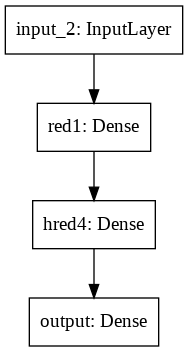

In [ ]:
# x_train = strat_train_set
# x_test = strat_test_set

del strat_test_set["T_bin"]
strat_test_set = strat_test_set.reset_index(drop=True)
T_test = strat_test_set["T"]
T_test = T_test.to_numpy()
del strat_test_set["T"]
strat_test_set = strat_test_set.to_numpy()

ValueError: ignored

(29962,)

In [ ]:
from sklearn.preprocessing import StandardScaler

# x_train_sc = StandardScaler().fit_transform(x_train)
# t_train = T_train
# x_test_sc = StandardScaler().fit_transform(x_test)
# t_test = T_test

model.compile(loss="binary_crossentropy", #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics="accuracy") #f1, precision, recall, crossentropy


In [ ]:
history = model.fit(strat_train_set, T_train, epochs=10,batch_size=128) # 32, 64, 128, 256)

Epoch 1/10
176/176 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.8284
Epoch 2/10
176/176 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.8578
Epoch 3/10
176/176 [==============================] - 0s 2ms/step - loss: 0.3106 - accuracy: 0.8631
Epoch 4/10
176/176 [==============================] - 0s 2ms/step - loss: 0.3111 - accuracy: 0.8632
Epoch 5/10
176/176 [==============================] - 0s 2ms/step - loss: 0.3132 - accuracy: 0.8646
Epoch 6/10
176/176 [==============================] - 0s 2ms/step - loss: 0.3090 - accuracy: 0.8606
Epoch 7/10
176/176 [==============================] - 0s 2ms/step - loss: 0.3138 - accuracy: 0.8631
Epoch 8/10
176/176 [==============================] - 0s 2ms/step - loss: 0.2996 - accuracy: 0.8639
Epoch 9/10
176/176 [==============================] - 0s 2ms/step - loss: 0.2945 - accuracy: 0.8652
Epoch 10/10
176/176 [==============================] - 0s 2ms/step - loss: 0.2931 - accuracy: 0.8671

In [ ]:
model.evaluate(strat_test_set, T_test)
# accuracy = model.evaluate(x_test,t_test)

176/176 [==============================] - 0s 867us/step - loss: 0.3398 - accuracy: 0.8413


[0.33981195092201233, 0.8412981629371643]

In [ ]:
t_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
strat_train_set = strat_train_set.reset_index(drop=True)


In [ ]:
strat_train_set[0].shape

(12,)

In [ ]:
corr_matrix = df.corr()
# corr_matrix["median_house_value"]





In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = StandardScaler().fit_transform(df)
dfn = pd.DataFrame(x, columns=["m1", "std1","e1", "m2","std2", "e2","m3", "std3","e3", "m4","std4", "e4"])
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
PCADf = pd.DataFrame(data = principalComponents, columns = ['pc_1', 'pc_2', 'pc_3'])

In [ ]:
pca.explained_variance_ratio_

array([0.57359973, 0.20821189, 0.06901825])

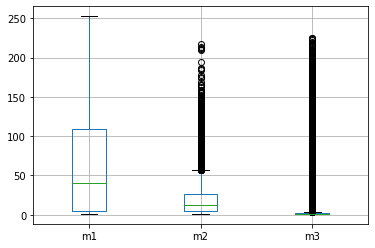

In [ ]:
df.boxplot(column=["m1", "m2", "m3"])

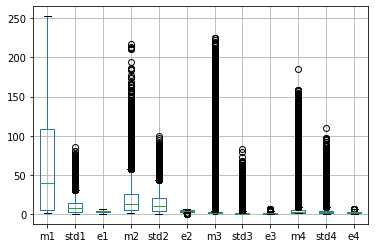

In [ ]:
df.boxplot(column=["m1", "std1","e1", "m2","std2", "e2","m3", "std3","e3", "m4","std4", "e4"])

In [ ]:
df.cov()

,m1,std1,e1,m2,std2,e2,m3,std3,e3,m4,std4,e4
m1,5467.795731,354.320150,60.051136,790.543633,568.087801,60.319981,696.775780,303.239101,77.871166,714.402968,565.938889,84.297874
std1,354.320150,86.542734,10.003048,110.144737,78.683270,8.715736,3.009499,11.890103,5.284819,36.350641,37.110881,7.857607
e1,60.051136,10.003048,2.532261,15.617807,11.876165,2.246623,-0.084125,1.349614,0.917566,3.674640,4.115584,1.557808
m2,790.543633,110.144737,15.617807,384.758707,226.830950,16.511651,52.417578,35.897397,12.209676,126.672516,102.037660,16.256721
std2,568.087801,78.683270,11.876165,226.830950,178.218057,13.207274,56.052734,31.558043,9.232068,89.769073,77.135728,12.250568
e2,60.319981,8.715736,2.246623,16.511651,13.207274,2.340703,3.896835,2.410844,0.995281,5.696251,5.494777,1.573080
m3,696.775780,3.009499,-0.084125,52.417578,56.052734,3.896835,351.185417,104.150532,14.912153,210.148204,146.949045,12.147190
std3,303.239101,11.890103,1.349614,35.897397,31.558043,2.410844,104.150532,42.786044,6.420198,81.062327,60.545454,5.457112
e3,77.871166,5.284819,0.917566,12.209676,9.232068,0.995281,14.912153,6.420198,1.635428,14.001668,10.973822,1.586313
m4,714.402968,36.350641,3.674640,126.672516,89.769073,5.696251,210.148204,81.062327,14.001668,248.963570,170.584161,13.505584


In [ ]:
df.corr()

,m1,std1,e1,m2,std2,e2,m3,std3,e3,m4,std4,e4
m1,1.000000,0.515080,0.510341,0.545036,0.575484,0.533190,0.502827,0.626943,0.823483,0.612307,0.651395,0.799261
std1,0.515080,1.000000,0.675714,0.603607,0.633565,0.612372,0.017263,0.195398,0.444221,0.247645,0.339521,0.592179
e1,0.510341,0.675714,1.000000,0.500347,0.559044,0.922790,-0.002821,0.129660,0.450887,0.146350,0.220119,0.686338
m2,0.545036,0.603607,0.500347,1.000000,0.866228,0.550203,0.142598,0.279781,0.486737,0.409280,0.442738,0.581055
std2,0.575484,0.633565,0.559044,0.866228,1.000000,0.646642,0.224054,0.361396,0.540764,0.426170,0.491768,0.643367
e2,0.533190,0.612372,0.922790,0.550203,0.646642,1.000000,0.135916,0.240904,0.508694,0.235965,0.305673,0.720868
m3,0.502827,0.017263,-0.002821,0.142598,0.224054,0.135916,1.000000,0.849654,0.622238,0.710705,0.667389,0.454450
std3,0.626943,0.195398,0.129660,0.279781,0.361396,0.240904,0.849654,1.000000,0.767506,0.785417,0.787792,0.584911
e3,0.823483,0.444221,0.450887,0.486737,0.540764,0.508694,0.622238,0.767506,1.000000,0.693899,0.730337,0.869664
m4,0.612307,0.247645,0.146350,0.409280,0.426170,0.235965,0.710705,0.785417,0.693899,1.000000,0.920135,0.600100


In [ ]:
x.shape

(28037, 13)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
#from tensorflow import keras
print(tf.__version__)

2.3.0


In [ ]:
np.max(backgnd_list[:])
backgnd = np.asarray(backgnd_list)


255.0

In [ ]:
backgnd.shape

(28037, 30, 36)